In [1]:
import pandas as pd
import numpy as np
import datetime 
import time
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

# To Plot matplotlib figures inline on the notebook
%matplotlib inline

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import grid_search
from sklearn.model_selection import GridSearchCV

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [3]:
data = pd.read_csv('Traffic_Crashes_-_Crashes.csv')

In [4]:
### Setting up the data table again

In [4]:
data=data.drop(['STATION','NAME','DATE','CRASH_DATE','POSTED_SPEED_LIMIT','CRASH_DATE_ADJ'], axis=1)
columns = ['WEATHER_CONDITION', 'LIGHTING_CONDITION', 'BEAT_OF_OCCURRENCE']
for col in columns:
    tmp_df = pd.get_dummies(data[col], prefix=col)
    data = pd.concat((data, tmp_df), axis=1)
data=data.drop(['WEATHER_CONDITION','LIGHTING_CONDITION','BEAT_OF_OCCURRENCE'], axis=1)
data=data.drop(['COUNTER'], axis=1)
data['INJURIES_TOTAL'].apply(lambda x: (x and 0) or x > 1)
data['ACCIDENT_LEVEL']=(data['INJURIES_TOTAL'] > 0).astype(int)
data=data.drop(['INJURIES_TOTAL','INJURIES_FATAL'], axis=1)
X = data.iloc[:, 0:293]
y = data.ACCIDENT_LEVEL

In [5]:
#Check out y counts for no injures and injuries

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state=42)

In [56]:
y_train.value_counts()

0    147945
1     18449
Name: ACCIDENT_LEVEL, dtype: int64

In [57]:
y_test.value_counts()

0    16408
1     2081
Name: ACCIDENT_LEVEL, dtype: int64

In [9]:
# Upsampling to even out ratios 

In [34]:
from collections import Counter
from imblearn.over_sampling import SMOTE 

'''Increase the injuries samples from 18449 to 100,000'''

sm = SMOTE(random_state=42,ratio={1:110000})
#what happens if I down
X_res, y_res = sm.fit_sample(X_train, y_train)
print('Resampled dataset shape {}'.format(Counter(y_res)))

Resampled dataset shape Counter({0: 147945, 1: 110000})


In [35]:
#Train, Test, Split

In [36]:
'''Split the resampled data into train & test data with 70:30 mix'''

Xtrain_res, Xtest_res, ytrain_res, ytest_res = train_test_split(X_res, y_res, test_size=0.30, random_state=0)
print('xtrain shape')
print(Xtrain_res.shape)
print('xtest shape')
print(Xtest_res.shape)

xtrain shape
(180561, 293)
xtest shape
(77384, 293)


In [42]:
from sklearn.linear_model import LogisticRegression

logitreg_gs = LogisticRegression()
parameters = {'penalty':['l1','l2'] , 'C' : [15,16,17,18,19,20,21], 'random_state': [44]}
grid_lr = GridSearchCV(logitreg_gs , parameters, cv=3, scoring='f1_weighted', n_jobs=1)
grid_lr.fit(Xtrain_res, ytrain_res)
print(grid_lr.best_params_, grid_lr.best_score_)
#15 

{'C': 19, 'penalty': 'l2', 'random_state': 44} 0.5569230532605478


In [43]:
print(classification_report(y_train, grid_lr.predict(X_train)))
print(confusion_matrix(y_train, grid_lr.predict(X_train)))


             precision    recall  f1-score   support

          0       0.90      0.82      0.86    147945
          1       0.17      0.30      0.22     18449

avg / total       0.82      0.76      0.79    166394

[[120680  27265]
 [ 12841   5608]]


In [44]:
print(classification_report(y_test, grid_lr.predict(X_test)))
print(confusion_matrix(y_test, grid_lr.predict(X_test)))

             precision    recall  f1-score   support

          0       0.90      0.81      0.85     16408
          1       0.17      0.30      0.22      2081

avg / total       0.82      0.75      0.78     18489

[[13332  3076]
 [ 1457   624]]


## KNN SMOTE

In [10]:
from sklearn.neighbors import KNeighborsClassifier


In [11]:
n_neighbors = range(1,12)
knn_accuracy = list()
knn_recall = list()

for n in n_neighbors:
    knn = KNeighborsClassifier(n)
    knn.fit(Xtrain_res, ytrain_res)
    knn_prediction = knn.predict(Xtest_res)
    knn_accuracy.append(accuracy_score(ytest_res, knn_prediction))
    knn_recall.append(recall_score(ytest_res, knn_prediction))
    

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(9,9), dpi=120)
plt.plot(n_neighbors, knn_accuracy)
plt.plot(n_neighbors, knn_recall)
plt.xlabel('# of neighbors (k)')
plt.ylabel('Accuracy, Recall on test set')
plt.title('KNN Model - Accuracy, Recall vs Neighbors')

In [31]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=2) 
knn.fit(Xtrain_res, ytrain_res)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=2, p=2,
           weights='uniform')

In [32]:
from sklearn.metrics import confusion_matrix
confusion_matrix(ytrain_res, knn.predict(Xtrain_res))
confusion_matrix(ytest_res, knn.predict(Xtest_res))

array([[29956, 19412],
       [ 5619, 43591]])

# Naive Baise SMOTE

In [14]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(Xtrain_res, ytrain_res)
print(nb.score(X_train, y_train))
print(nb.score(X_test, y_test))

0.48604516989795304
0.4794201957920926


In [15]:
from sklearn.metrics import confusion_matrix, classification_report

In [16]:
print(classification_report(y_train, nb.predict(X_train)))
print(confusion_matrix(y_train, nb.predict(X_train)))


             precision    recall  f1-score   support

          0       0.91      0.47      0.62    147945
          1       0.13      0.63      0.21     18449

avg / total       0.82      0.49      0.57    166394

[[69284 78661]
 [ 6858 11591]]


In [17]:
print(classification_report(y_test, nb.predict(X_test)))
print(confusion_matrix(y_test, nb.predict(X_test)))


             precision    recall  f1-score   support

          0       0.90      0.46      0.61     16408
          1       0.13      0.61      0.21      2081

avg / total       0.82      0.48      0.57     18489

[[7593 8815]
 [ 810 1271]]


# Random Forest SMOTE

In [20]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
import sklearn.metrics as mt

In [22]:
rf = RandomForestClassifier(n_estimators = 22) #20
rf.fit(Xtrain_res, ytrain_res)
       
rf_predictions = rf.predict(X_test)

#print(rf.score(X_test, y_test))
scores = cross_val_score(rf, X_test, y_test, cv=3)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)\n" % (scores.mean(), scores.std() * 2))

print(mt.classification_report(y_test, rf_predictions))
print(mt.confusion_matrix(y_test, rf_predictions))

[0.87410772 0.87489859 0.87406686]
Accuracy: 0.87 (+/- 0.00)

             precision    recall  f1-score   support

          0       0.89      0.96      0.92     16408
          1       0.16      0.06      0.09      2081

avg / total       0.81      0.86      0.83     18489

[[15725   683]
 [ 1948   133]]


### Gridsearch on Random Forest

In [40]:
rfgrid = RandomForestClassifier()
parameters = {'criterion':['gini','entropy'],'n_estimators': [30,31,32,33,34],'max_features': ['auto', 'sqrt'], 'random_state': [2]}
gridrf = GridSearchCV(rfgrid , parameters, cv=2, scoring='f1_weighted', n_jobs=1)
gridrf.fit(Xtrain_res, ytrain_res)

GridSearchCV(cv=2, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'criterion': ['gini', 'entropy'], 'n_estimators': [30, 31, 32, 33, 34], 'max_features': ['auto', 'sqrt'], 'random_state': [2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_weighted', verbose=0)

In [41]:
print(gridrf.best_params_, gridrf.best_score_)

#*****************************

{'criterion': 'entropy', 'max_features': 'auto', 'n_estimators': 31, 'random_state': 2} 0.8958138232764536


### Testing on regular data with fitted random forest 

In [48]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 31) #24 #22 #20
rf.fit(Xtrain_res, ytrain_res)

rf_predictions = rf.predict(X_test)

#print(rf.score(X_test, y_test))
scores = cross_val_score(rf, X_test, y_test, cv=3)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)\n" % (scores.mean(), scores.std() * 2))

print(mt.classification_report(y_test, rf_predictions))
print(mt.confusion_matrix(y_test, rf_predictions))

[0.88 0.87 0.87]
Accuracy: 0.88 (+/- 0.00)

             precision    recall  f1-score   support

          0       0.89      0.96      0.92     16408
          1       0.17      0.07      0.10      2081

avg / total       0.81      0.86      0.83     18489

[[15693   715]
 [ 1939   142]]


In [49]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 25) #24 #22 #20
rf.fit(Xtrain_res, ytrain_res)

rf_predictions = rf.predict(X_test)

#print(rf.score(X_test, y_test))
scores = cross_val_score(rf, X_test, y_test, cv=3)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)\n" % (scores.mean(), scores.std() * 2))

print(mt.classification_report(y_test, rf_predictions))
print(mt.confusion_matrix(y_test, rf_predictions))

[0.87 0.87 0.87]
Accuracy: 0.87 (+/- 0.00)

             precision    recall  f1-score   support

          0       0.89      0.96      0.92     16408
          1       0.16      0.06      0.09      2081

avg / total       0.81      0.86      0.83     18489

[[15692   716]
 [ 1947   134]]


# Decision Tree

In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier


dt = DecisionTreeClassifier()

In [82]:
dt.fit(Xtrain_res, ytrain_res)
dt.score(Xtest_res, ytest_res)

0.8878248696463714

### Gridsearch on Decision Tree

In [31]:
dt_gs = DecisionTreeClassifier()
parameters = {'criterion':['gini','entropy'],'max_depth': [6,7,8,9,10,11], 'random_state': [3]}
dt_gs = GridSearchCV(dt_gs , parameters, cv=3, scoring='f1_weighted', n_jobs=1)
dt_gs.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [6, 7, 8, 9, 10, 11], 'random_state': [3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_weighted', verbose=0)

In [32]:
print(dt_gs.best_params_, dt_gs.best_score_)

{'criterion': 'gini', 'max_depth': 7, 'random_state': 3} 0.8371208305444873


In [33]:
print(mt.classification_report(y_test, dt_gs.predict(X_test)))
print(mt.confusion_matrix(y_test, dt_gs.predict(X_test)))

             precision    recall  f1-score   support

          0       0.89      1.00      0.94     16408
          1       0.10      0.00      0.00      2081

avg / total       0.80      0.89      0.83     18489

[[16389    19]
 [ 2079     2]]


# XGBoosted

In [ ]:
import xgboost as xgb


Xtrain_res_, Xtrain_res_val_, ytrain_res_, ytrain_res_val_ = train_test_split(Xtrain_res, ytrain_res, test_size=0.25, random_state=41)


In [ ]:
gbm = xgb.XGBClassifier(
                       n_estimators=800000, #arbitrary large number
                       max_depth=7,
                       objective='binary:logistic',
                       learning_rate=.08, #.1
                       subsample=1,
                       min_child_weight=6, #
                       colsample_bytree=.8
                      )

eval_set=[(X_train,y_train),(X_val,y_val)] #tracking train/validation error as we go
fit_model = gbm.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='error',
                    early_stopping_rounds=9,
                    verbose=True #gives output log as below
                   )

# BEST MODEL: Random Forest

In [46]:
import itertools
import seaborn as sns

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges): #plt.cm.Oranges
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = (100*cm.astype('float')) / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[15702   706]
 [ 1944   137]]
Normalized confusion matrix
[[95.7   4.3 ]
 [93.42  6.58]]


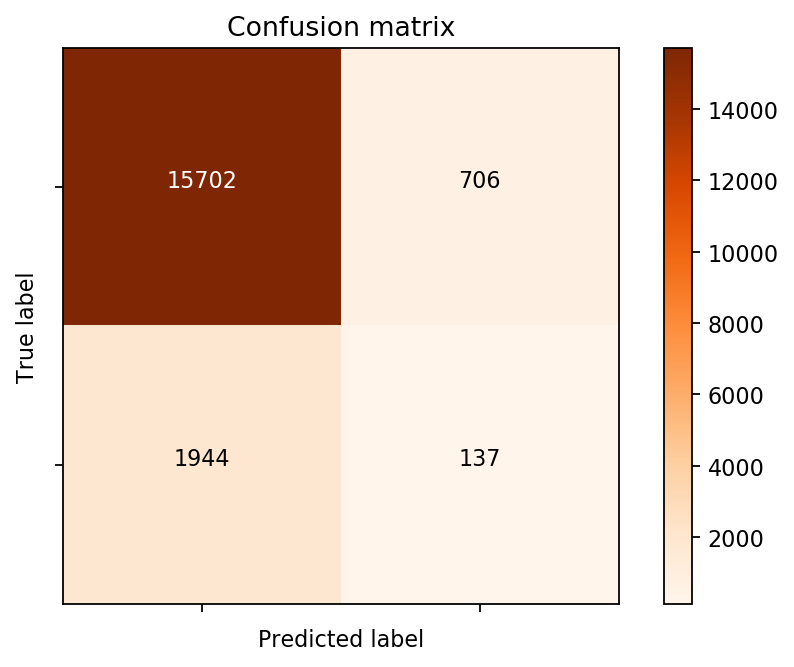

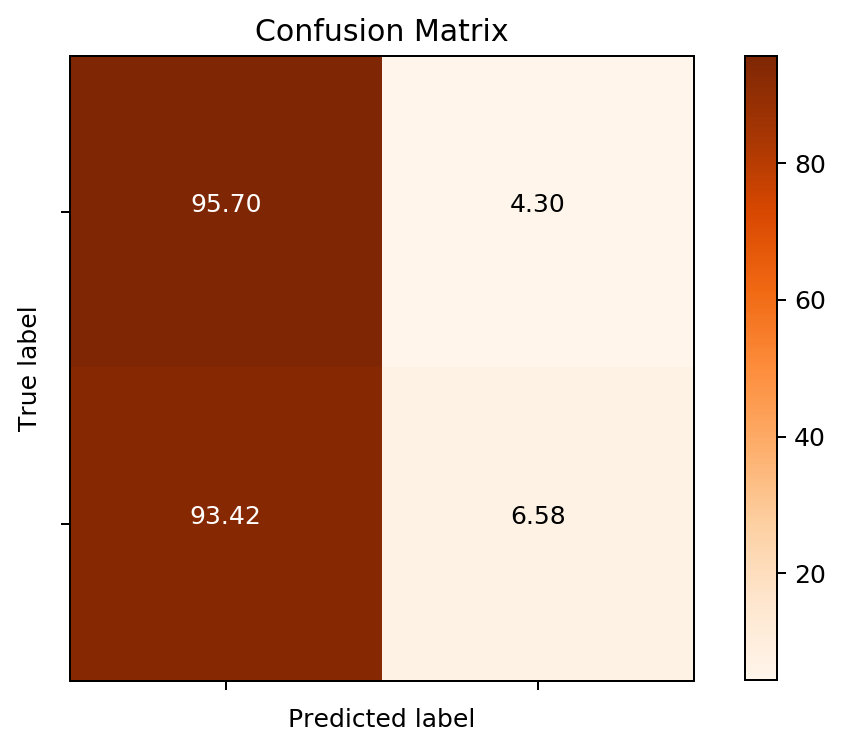

In [47]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, rf.predict(X_test))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(dpi=160)
plot_confusion_matrix(cnf_matrix, classes=['', ''], title='Confusion matrix')

# Plot normalized confusion matrix
plt.figure(dpi=180)
plot_confusion_matrix(cnf_matrix, classes=['', ''], normalize=True, title='Confusion Matrix')

plt.show()

Confusion matrix, without normalization
[[13332  3076]
 [ 1457   624]]
Normalized confusion matrix
[[81.25 18.75]
 [70.01 29.99]]


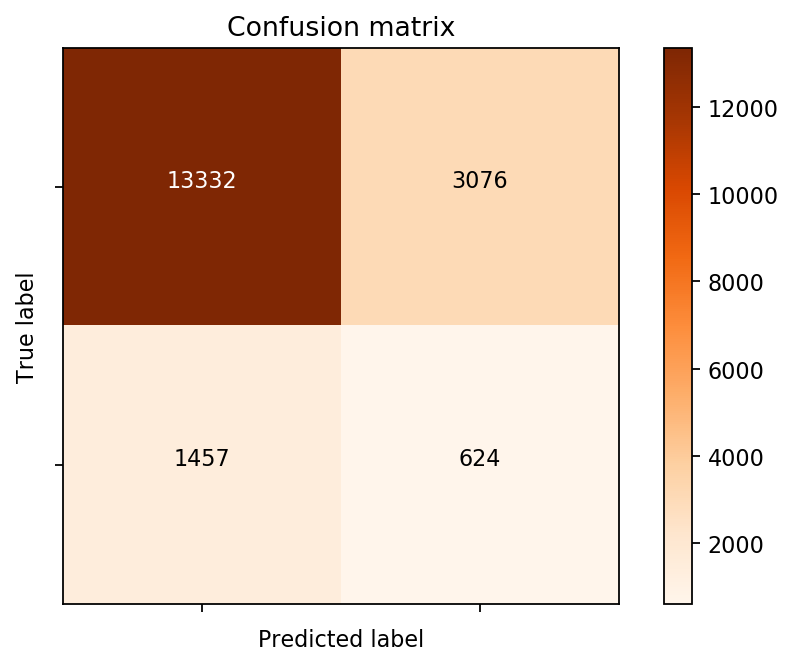

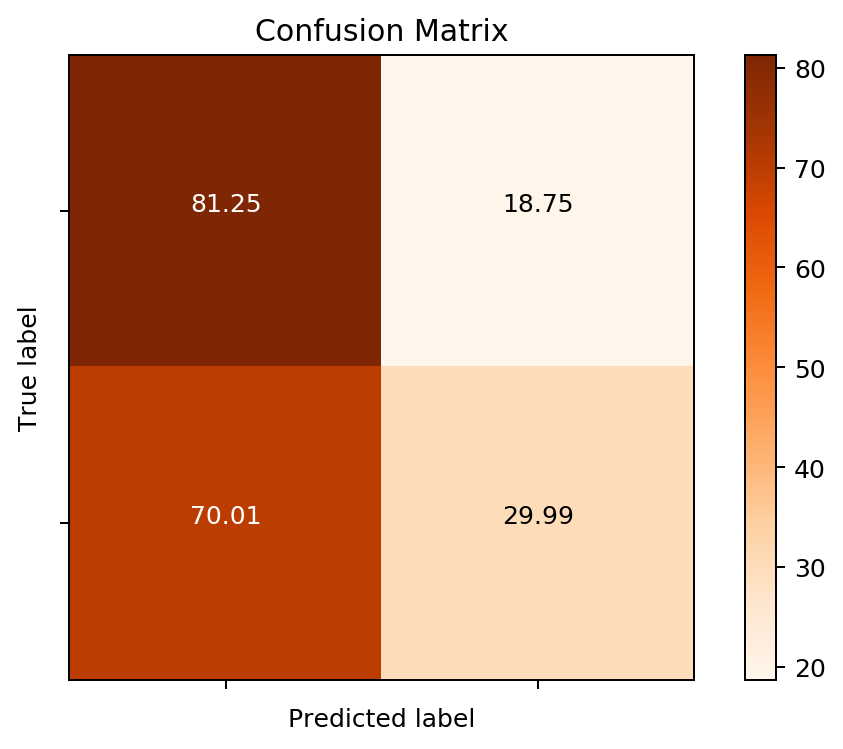

In [50]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, grid_lr.predict(X_test))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(dpi=160)
plot_confusion_matrix(cnf_matrix, classes=['', ''], title='Confusion matrix')

# Plot normalized confusion matrix
plt.figure(dpi=180)
plot_confusion_matrix(cnf_matrix, classes=['', ''], normalize=True, title='Confusion Matrix')

plt.show()

## ***************** Recommendations *****************

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                stratify=y, 
                                                test_size=0.10)

In [59]:
y_train.value_counts()

0    147917
1     18477
Name: ACCIDENT_LEVEL, dtype: int64

In [60]:
y_test.value_counts()

0    16436
1     2053
Name: ACCIDENT_LEVEL, dtype: int64

In [79]:
from collections import Counter
from imblearn.over_sampling import SMOTE 

'''Increase the injuries samples from 16436 to 115,000'''

sm = SMOTE(random_state=8,ratio={0:147917,1:115000})

X_res, y_res = sm.fit_sample(X_train, y_train)
print('Resampled dataset shape {}'.format(Counter(y_res)))

Resampled dataset shape Counter({0: 147917, 1: 115000})


In [80]:
'''Split the resampled data into train & test data with 70:30 mix'''

Xtrain_res, Xtest_res, ytrain_res, ytest_res = train_test_split(X_res, y_res, stratify=y_res, test_size=0.30, random_state=5)
print('xtrain shape')
print(Xtrain_res.shape)
print('xtest shape')
print(Xtest_res.shape)

xtrain shape
(184041, 293)
xtest shape
(78876, 293)


In [ ]:
#Logistic

In [81]:
from sklearn.linear_model import LogisticRegression

logitreg_gs = LogisticRegression()
parameters = {'penalty':['l1','l2'] , 'C' : [25,26,27,28,29,30], 'random_state': [44]}
grid_lr = GridSearchCV(logitreg_gs , parameters, cv=3, scoring='f1_weighted', n_jobs=1)
grid_lr.fit(Xtrain_res, ytrain_res)
print(grid_lr.best_params_, grid_lr.best_score_)
#15 

{'C': 27, 'penalty': 'l2', 'random_state': 44} 0.5608204172269488


In [82]:
print("TRAIN")
print(classification_report(y_train, grid_lr.predict(X_train)))
print(confusion_matrix(y_train, grid_lr.predict(X_train)))
print("TEST")
print(classification_report(y_test, grid_lr.predict(X_test)))
print(confusion_matrix(y_test, grid_lr.predict(X_test)))

TRAIN
             precision    recall  f1-score   support

          0       0.91      0.79      0.84    147917
          1       0.17      0.34      0.22     18477

avg / total       0.82      0.74      0.78    166394

[[117079  30838]
 [ 12264   6213]]
TEST
             precision    recall  f1-score   support

          0       0.90      0.79      0.84     16436
          1       0.16      0.32      0.21      2053

avg / total       0.82      0.74      0.77     18489

[[12950  3486]
 [ 1389   664]]


In [ ]:
#KNN

In [ ]:
n_neighbors = range(1,12)
knn_accuracy = list()
knn_recall = list()

for n in n_neighbors:
    knn = KNeighborsClassifier(n)
    knn.fit(Xtrain_res, ytrain_res)
    knn_prediction = knn.predict(Xtest_res)
    knn_accuracy.append(accuracy_score(ytest_res, knn_prediction))
    knn_recall.append(recall_score(ytest_res, knn_prediction))
    
plt.figure(figsize=(9,9), dpi=120)
plt.plot(n_neighbors, knn_accuracy)
plt.plot(n_neighbors, knn_recall)
plt.xlabel('# of neighbors (k)')
plt.ylabel('Accuracy, Recall on test set')
plt.title('KNN Model - Accuracy, Recall vs Neighbors')

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=2) 
knn.fit(Xtrain_res, ytrain_res)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(ytrain_res, knn.predict(Xtrain_res))
confusion_matrix(ytest_res, knn.predict(Xtest_res))

In [ ]:
#Random Forest

In [92]:
rfgrid = RandomForestClassifier()
parameters = {'criterion':['gini','entropy'],'n_estimators': [41,42,43,44],'max_features': ['auto'], 'random_state': [2]}
gridrf = GridSearchCV(rfgrid , parameters, cv=2, scoring='f1_weighted', n_jobs=1)
gridrf.fit(Xtrain_res, ytrain_res)

GridSearchCV(cv=2, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'criterion': ['gini', 'entropy'], 'n_estimators': [41, 43, 45, 47], 'max_features': ['auto'], 'random_state': [2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_weighted', verbose=0)

In [93]:
print(gridrf.best_params_, gridrf.best_score_)


{'criterion': 'entropy', 'max_features': 'auto', 'n_estimators': 43, 'random_state': 2} 0.8973059689315669


In [114]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 43) #24 #22 #20
rf.fit(Xtrain_res, ytrain_res)

rf_predictions = rf.predict(X_test)

scores = cross_val_score(rf, X_test, y_test, cv=3)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)\n" % (scores.mean(), scores.std() * 2))

print(mt.classification_report(y_test, rf_predictions))
print(mt.confusion_matrix(y_test, rf_predictions))

[0.87 0.87 0.87]
Accuracy: 0.87 (+/- 0.00)

             precision    recall  f1-score   support

          0       0.89      0.95      0.92     16436
          1       0.14      0.06      0.08      2053

avg / total       0.81      0.85      0.83     18489

[[15669   767]
 [ 1928   125]]


In [ ]:
#Decision Tree

In [111]:
dt_gs = DecisionTreeClassifier()
parameters = {'criterion':['gini','entropy'],'max_depth': [3,4,5,6], 'random_state': [3]}
dt_gs = GridSearchCV(dt_gs , parameters, cv=3, scoring='f1_weighted', n_jobs=1)
dt_gs.fit(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:113

GridSearchCV(cv=3, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [3, 4, 5, 6], 'random_state': [3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_weighted', verbose=0)

In [112]:
print(dt_gs.best_params_, dt_gs.best_score_)

{'criterion': 'gini', 'max_depth': 4, 'random_state': 3} 0.8367749780331769


In [113]:
print(mt.classification_report(y_test, dt_gs.predict(X_test)))
print(mt.confusion_matrix(y_test, dt_gs.predict(X_test)))

             precision    recall  f1-score   support

          0       0.89      1.00      0.94     16436
          1       0.50      0.00      0.00      2053

avg / total       0.85      0.89      0.84     18489

[[16435     1]
 [ 2052     1]]


Confusion matrix, without normalization
[[12950  3486]
 [ 1389   664]]
Normalized confusion matrix
[[78.79 21.21]
 [67.66 32.34]]


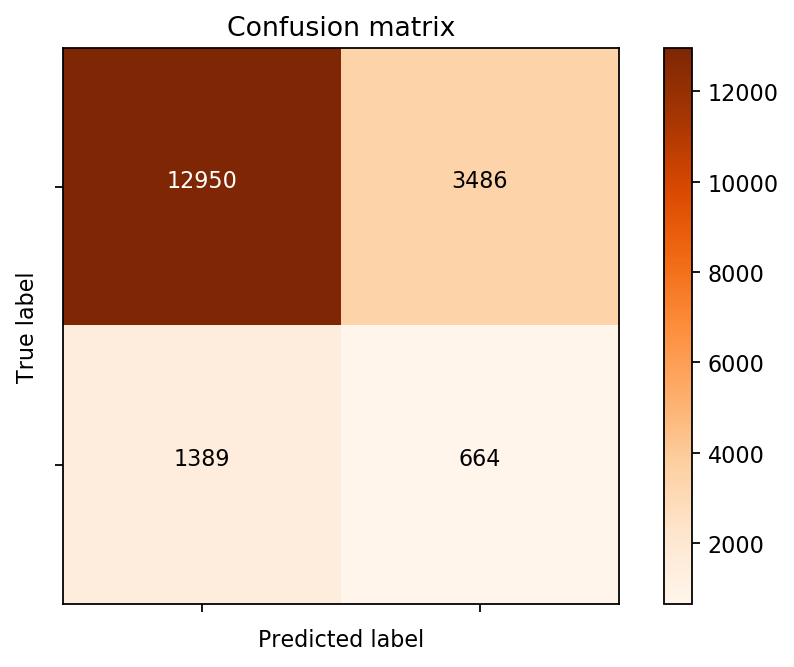

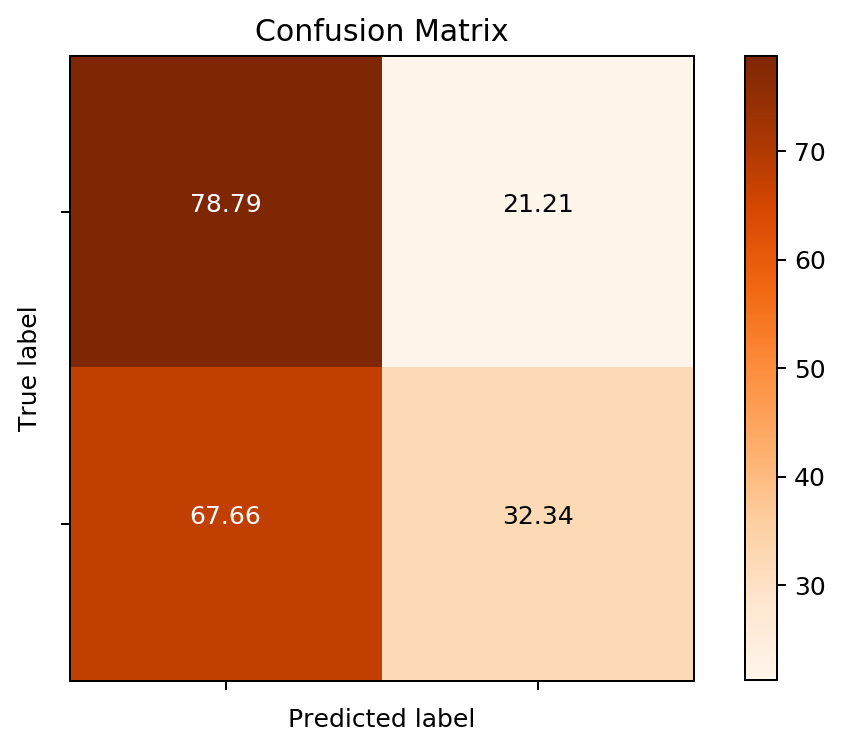

In [87]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, grid_lr.predict(X_test))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(dpi=160)
plot_confusion_matrix(cnf_matrix, classes=['', ''], title='Confusion matrix')

# Plot normalized confusion matrix
plt.figure(dpi=180)
plot_confusion_matrix(cnf_matrix, classes=['', ''], normalize=True, title='Confusion Matrix')

plt.show()

In [ ]:
# PCA

In [138]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(X_test)
pcafeatures_train = pca.transform(X_test)

In [139]:
datanames = ['injury', 'no_injury']

In [140]:
from itertools import cycle

def plot_PCA_2D(data, target, target_names):
    colors = cycle(['blue','orange'])
    target_ids = range(len(target_names))
    plt.figure(dpi=160) #dpi
    for i, c, label in zip(target_ids, colors, target_names):
        plt.scatter(data[target == i, 0], data[target == i, 1],
                   c=c,s=40, alpha = 0.9, label=label, edgecolors='gray')
    plt.legend()

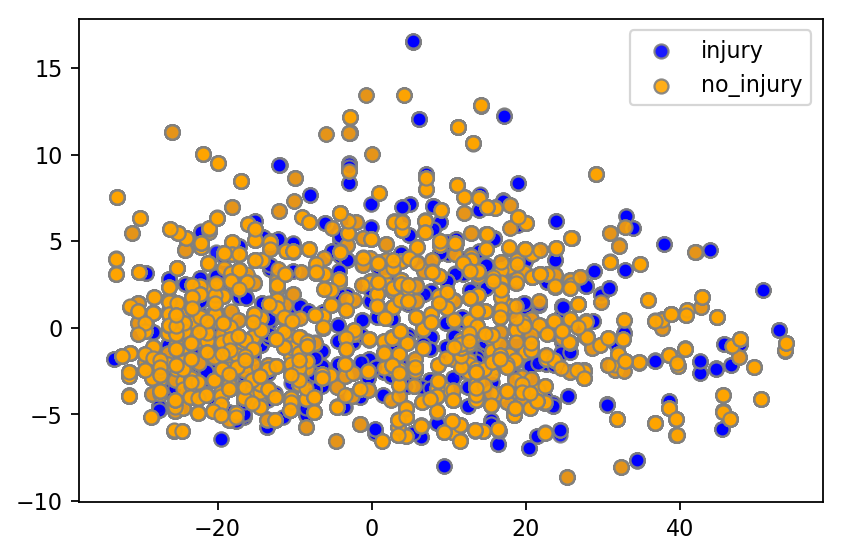

In [141]:
plot_PCA_2D(pcafeatures_train, target=y_test, target_names=datanames)